# Project Description:

This project focuses on sentiment analysis of movie reviews from the IMDB dataset. The goal is to classify movie reviews as either positive or negative using machine learning techniques. The project emphasizes data preprocessing, exploratory data analysis (EDA), text normalization, and experimentation with multiple models to identify the best-performing approach.

**1. Load and Inspect Data**
* Import libraries
* Load the IMDB dataset form a .tsv file.
* Check for missing / duplicated values

**2. EDA**
* Check number of movies and reviews over the years
* Check the distribution of number of reviews per movie
* Distribution of ratings for train and test set
* Number of reviews of different polarities per year

**3. Evaluation Procedure**
* Create a dictionary to store evaluation metrics to loop the train/test set
* Metrics Calculation using Accuracy, F1, APS, and ROC AUC
* Visualizations of metrics

**4. Text Normalization**
* Convert all text in reviews to lowercase
* Remove all digits from text
* Remove all punctuation and special characters

**5. Train / Test Split**
* Dataset already had split data so we needed to seperate them

**6. Model experiments**
* Constant model
* NLTK, TF-IDF and LR model
* SpaCy, TF-IDF and LR model
* SpaCy, TF-IDF and LGBMClassifier

**7. My Reviews**
* Testing my own reviews with the different models



## Initialization

In [105]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [106]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
tqdm.pandas()

## Load Data

In [107]:
#Load Dataset
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

df_reviews.head()

# Checking data types and basic summary
print("Dataset Information:")
df_reviews.info()
print("\n")

# Checking for missing values
print("Missing Values per Column:")
print(df_reviews.isnull().sum())
print("\n")

# Check for duplicate records
duplicate_rows = df_reviews[df_reviews.duplicated()]
print(f"Number of duplicate records: {duplicate_rows.shape[0]}")
print(duplicate_rows)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int6

In [108]:
# Drop rows where 'average_rating' or 'votes' have missing values
df_reviews = df_reviews.dropna(subset=['average_rating', 'votes'])

# Confirm the rows have been removed
print(f"Remaining rows after dropping missing values: {df_reviews.shape[0]}")

df_reviews.info()


Remaining rows after dropping missing values: 47329
<class 'pandas.core.frame.DataFrame'>
Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx        

## EDA

Let's check the number of movies and reviews over years.

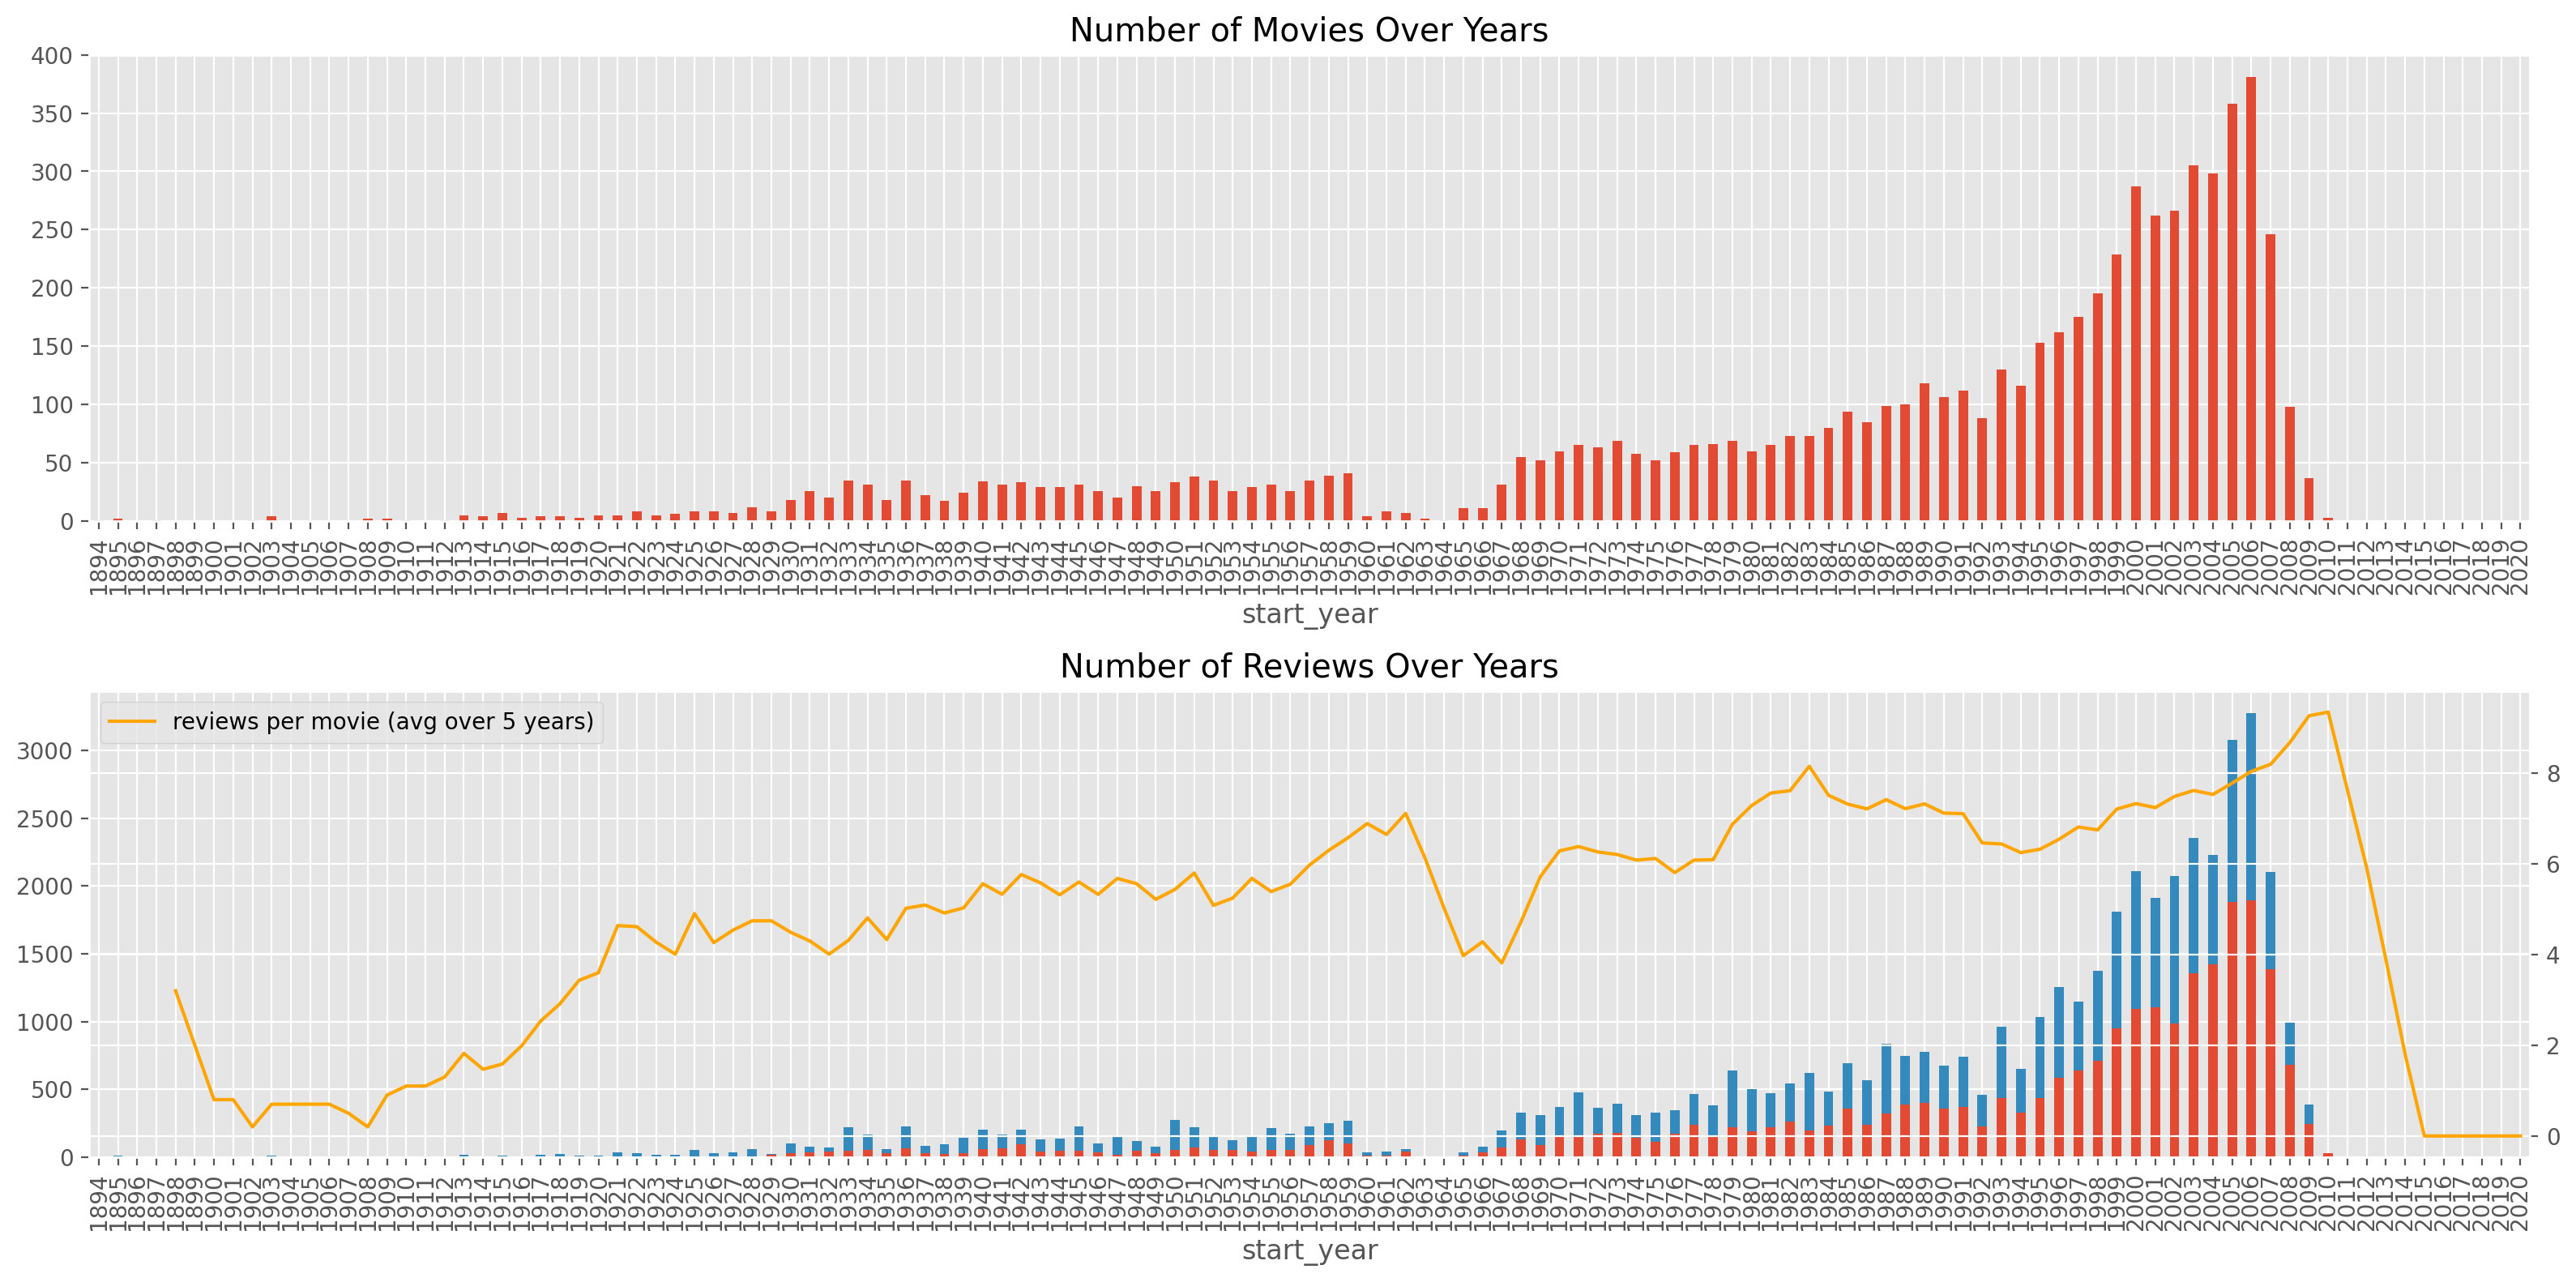

In [109]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

***Conclusion***

Both graphs are showing the number of reviews over all the years.  We can see that this dates back to 1894 - 2020. The peak reviews was in 2006 near 400 total reviews. 

**Insight:** These trends can help identify critical years or patterns in movie review sentiment, aligning with cultural and industry changes.

Let's check the distribution of number of reviews per movie with the exact counting and KDE 

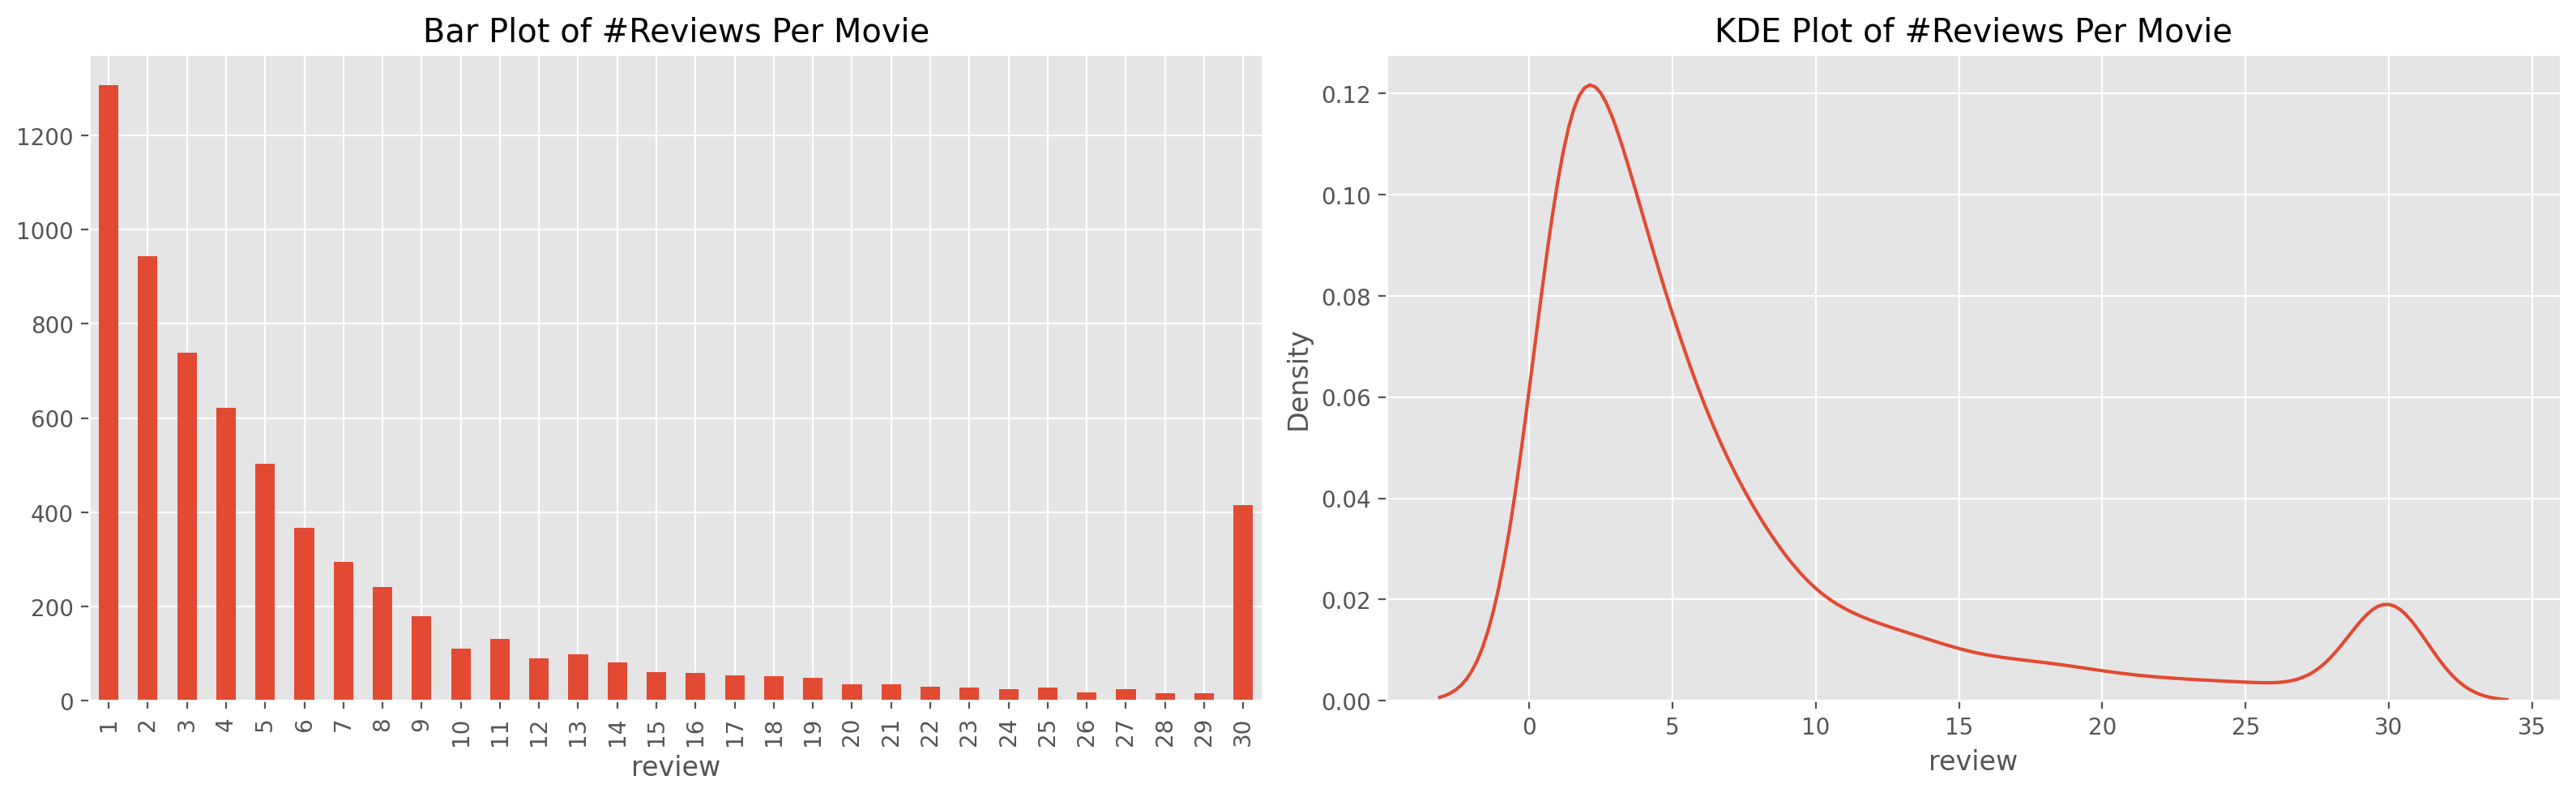

In [110]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

***Conclusion***

Both graphs are showing the number of reviews per movie. Stead decline with a random spike at the end. 

**Insight:** These trends can help identify critical years or patterns in movie review sentiment, aligning with cultural and industry changes.

In [111]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23614
Name: count, dtype: int64

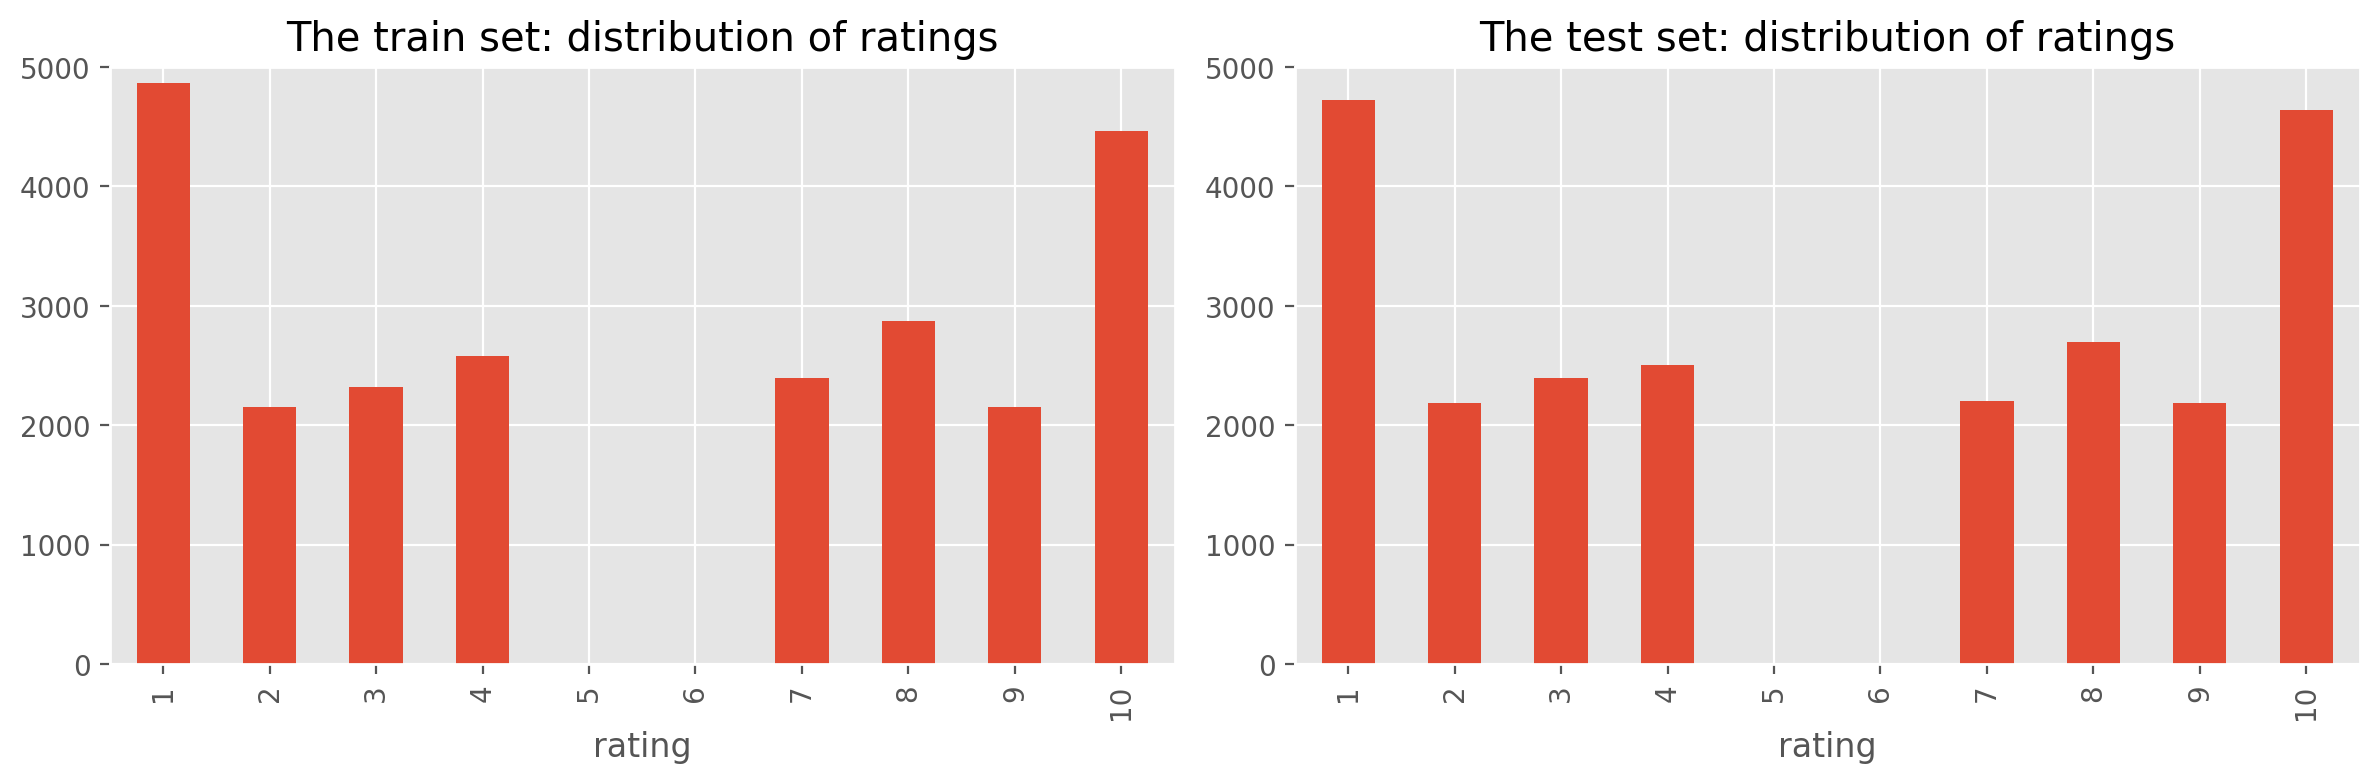

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

***Conclusion***

These show us the distribution of ratings for both the train and test set which are very simular to each other.  

**Insight:** These trends can help identify critical years or patterns in movie review sentiment, aligning with cultural and industry changes.

Distribution of negative and positive reviews over the years for two parts of the dataset

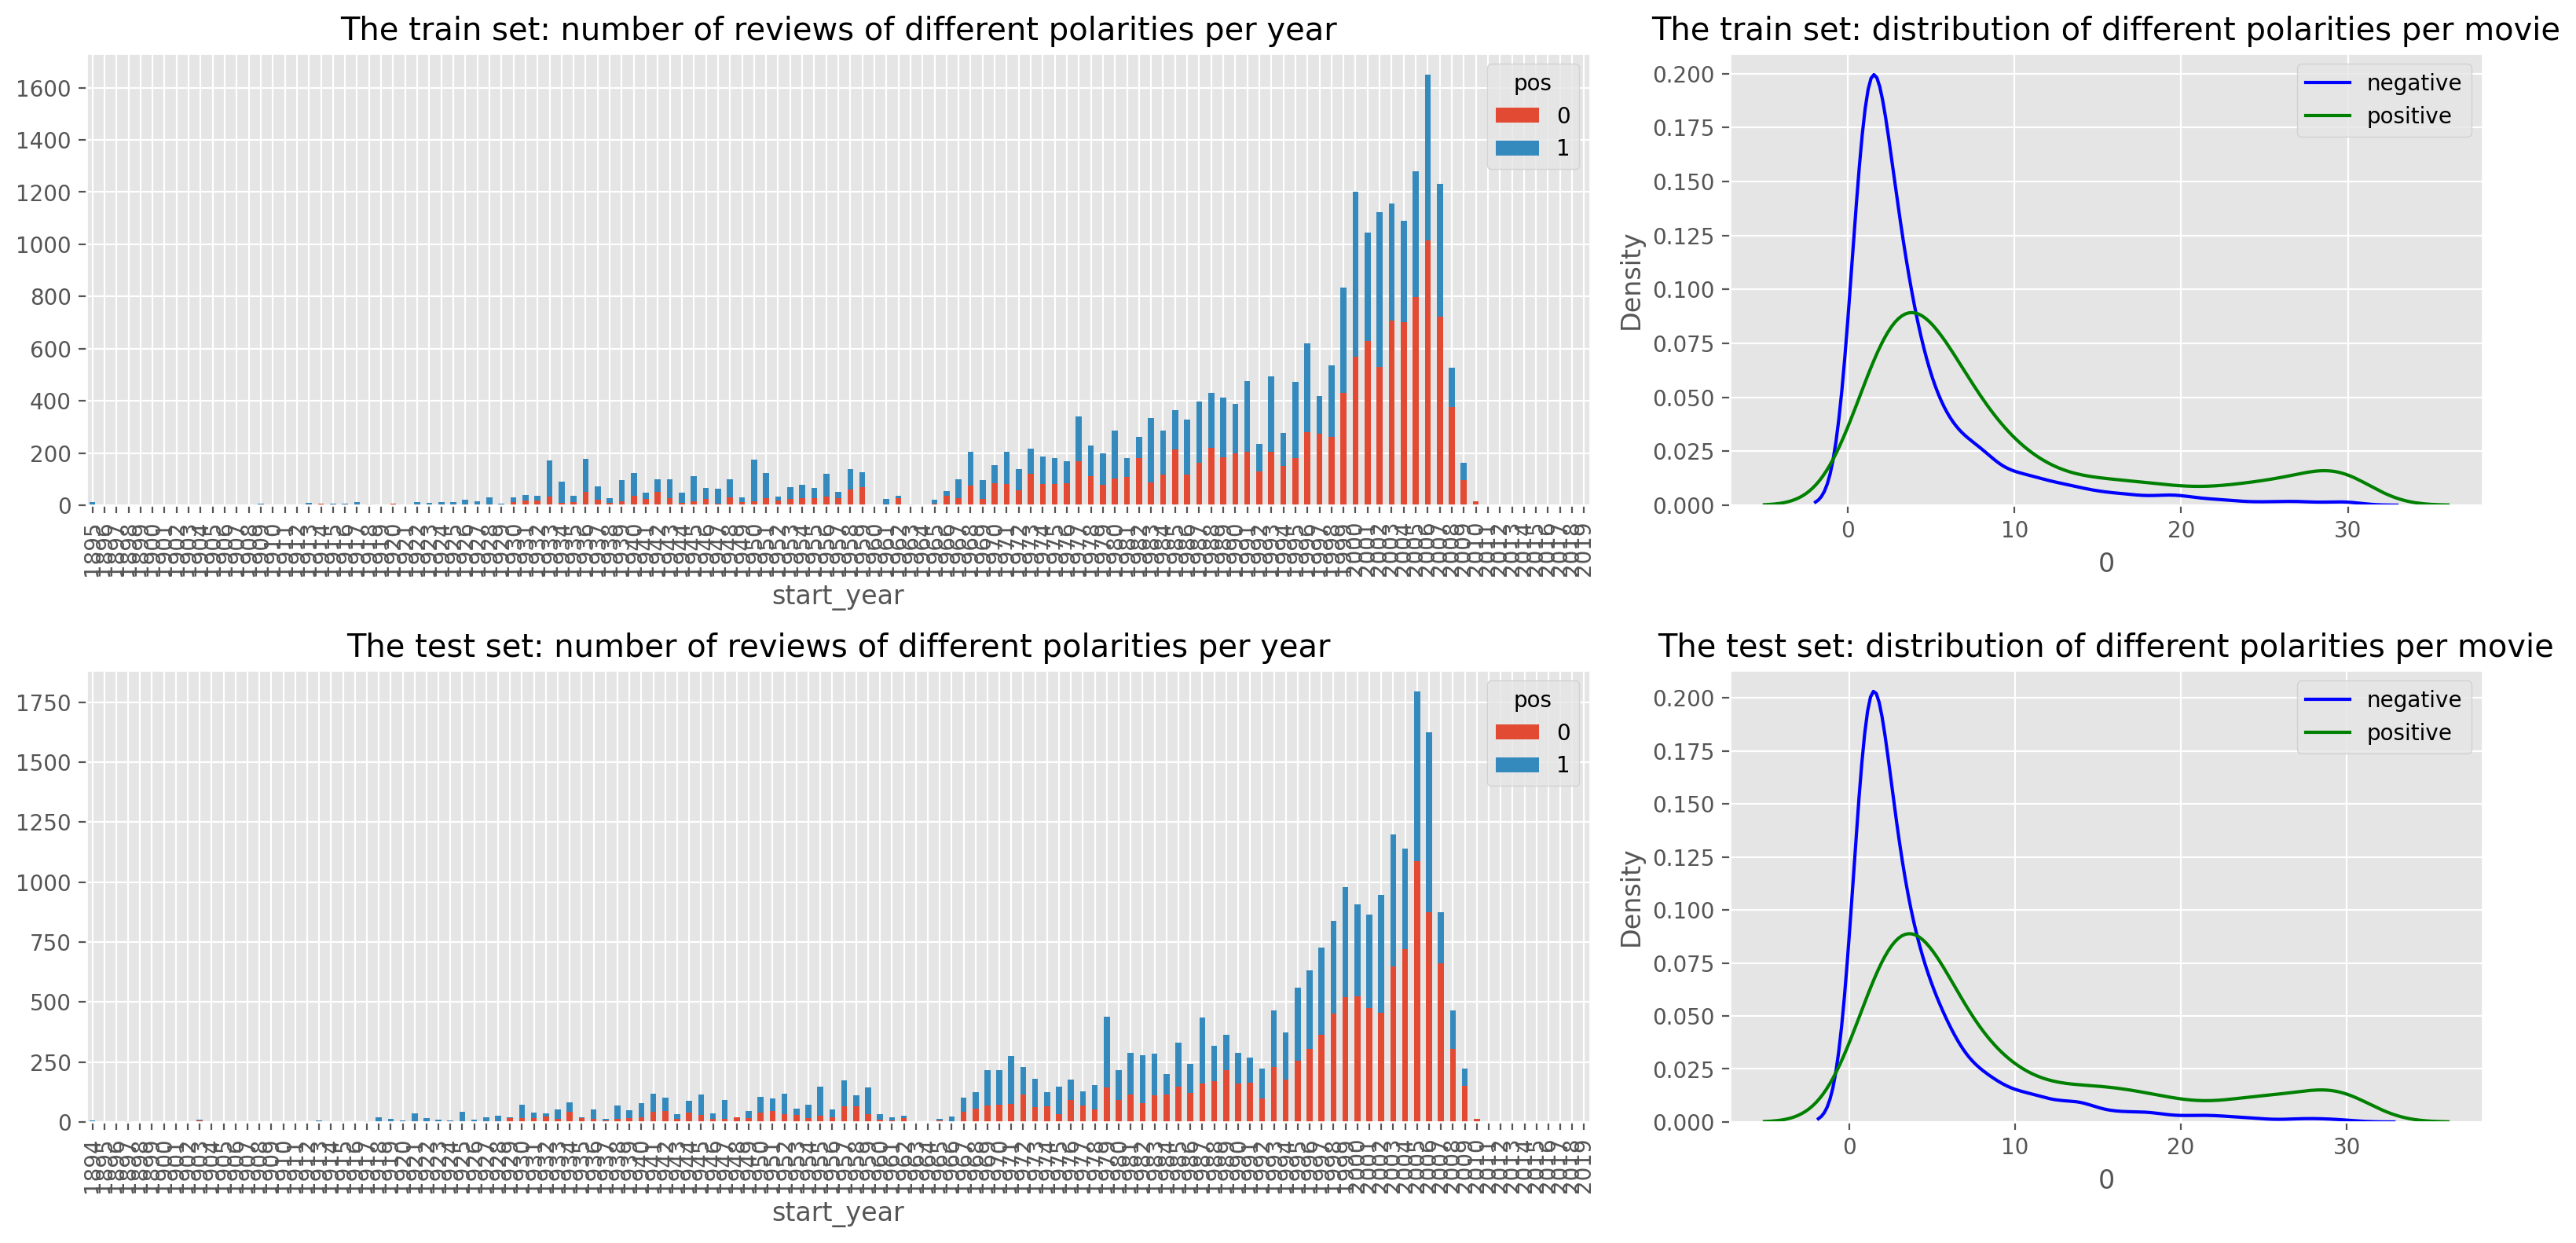

In [113]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# Top-Left Plot
ax = axs[0][0]
dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

# Top-Right Plot
ax = axs[0][1]
dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

# Bottom-Left Plot
ax = axs[1][0]
dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

# Bottom-Right Plot
ax = axs[1][1]
dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

***Conclusion***

Train set: The number of positive and negative reviews along with the density for each. 

Test set: A simular look at each graph for the number of reviews and density. 


**Insight:** These trends can help identify critical years or patterns in movie review sentiment, aligning with cultural and industry changes.

## Evaluation Procedure

In [114]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [115]:
df_reviews['review_norm'] = df_reviews['review'].str.lower() \
    .str.replace(r'\d+', '', regex=True) \
    .str.replace(r'[^\w\s]', '', regex=True) \
    .str.strip()

## Train / Test Split

In [116]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Working with models

### Model 0 - Constant

In [117]:
from sklearn.dummy import DummyClassifier

In [118]:
dummy_model = DummyClassifier(strategy="most_frequent")

In [119]:
dummy_model.fit(df_reviews_train['review_norm'], train_target)

DummyClassifier(strategy='most_frequent')

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


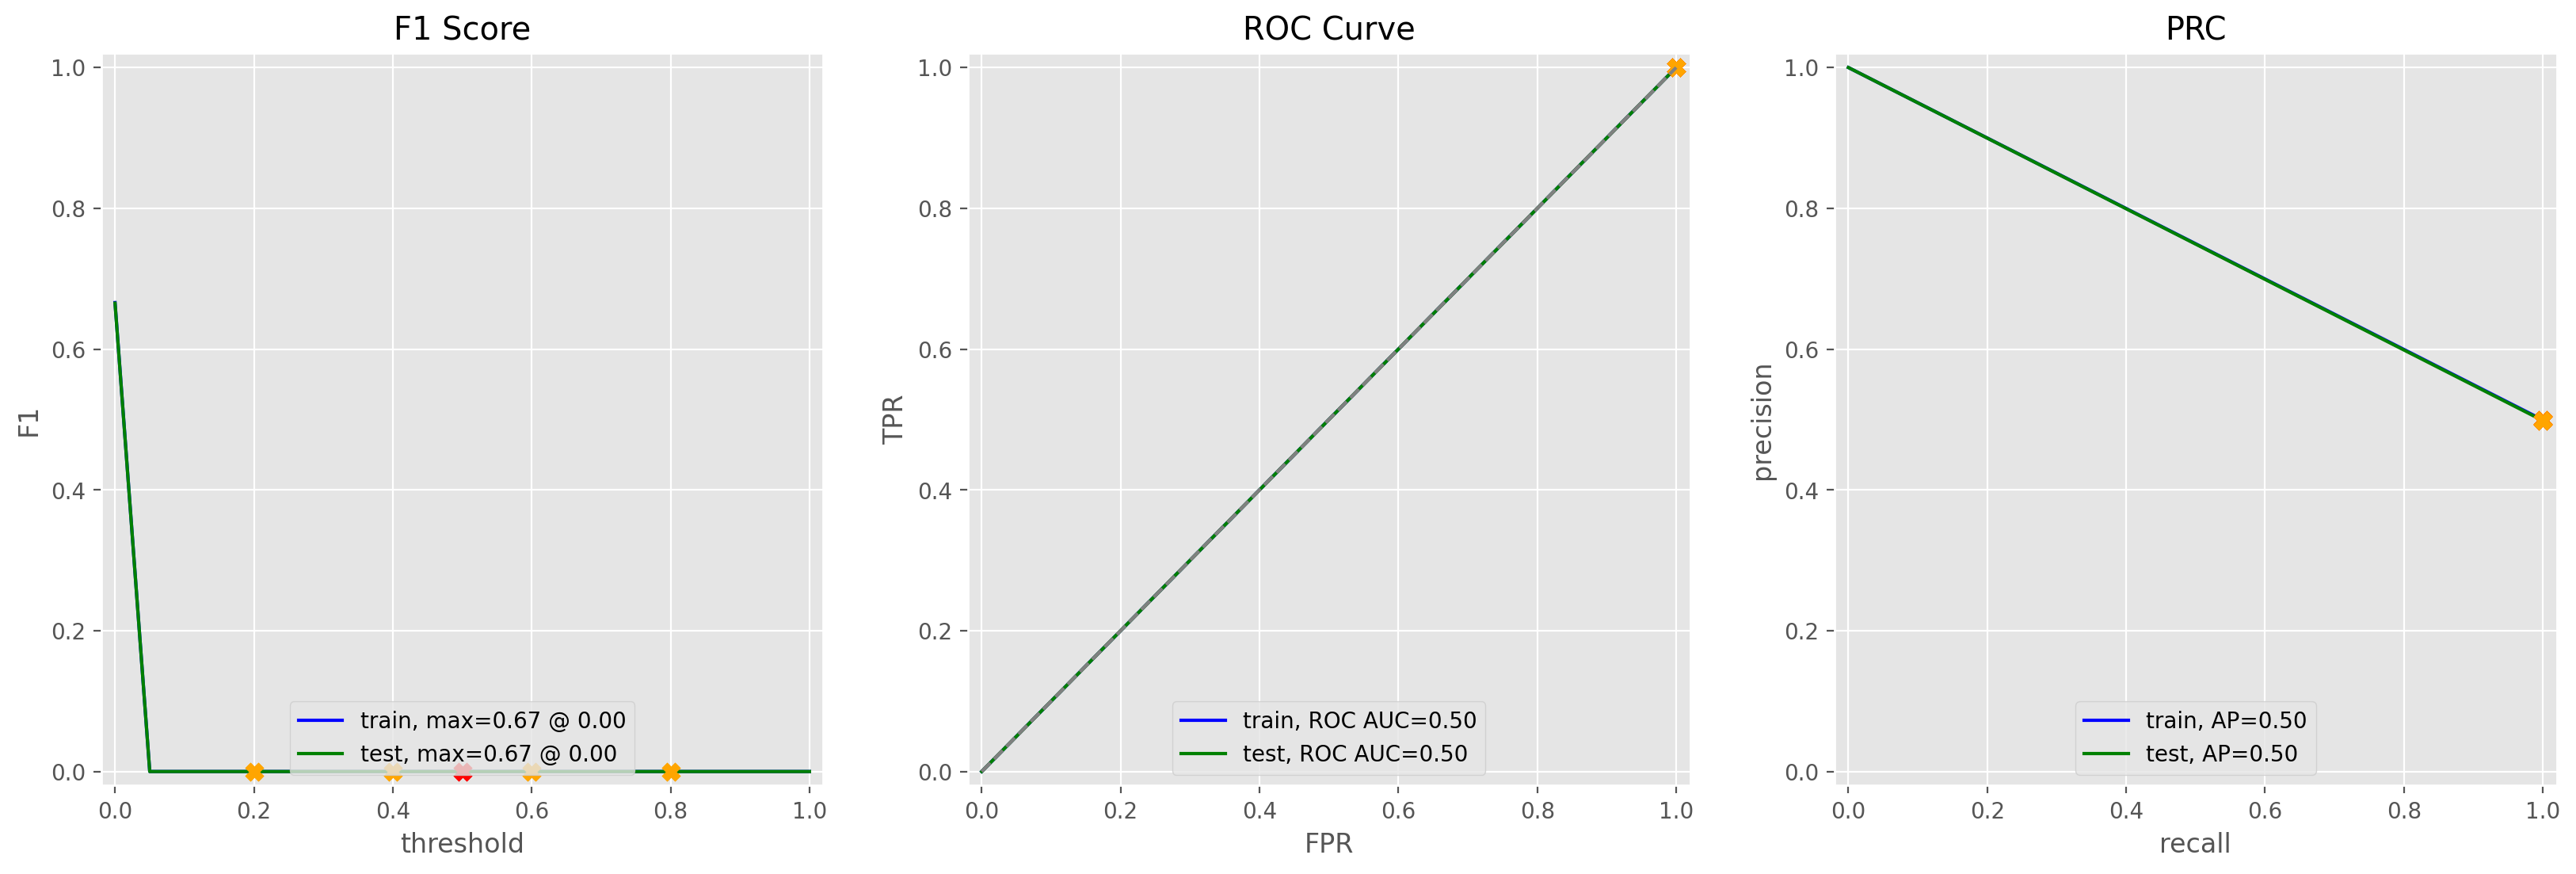

In [120]:
evaluate_model(dummy_model, df_reviews_train['review_norm'], train_target, df_reviews_test['review_norm'], test_target)

***Conclusion***

This is our baseline model that'll help us understand the minimum performance levels. All of the metrics are .5 for accuracy, F1, APS, and ROC AUC.

**Insight:** These trends can help identify critical years or patterns in movie review sentiment, aligning with cultural and industry changes.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [121]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [122]:
stop_words = list(set(stopwords.words('english')))

In [123]:
#Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=100)

In [124]:
train_features_1 = tfidf_vectorizer.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer.transform(df_reviews_test['review_norm'])

In [125]:
#Initialize Logistic Regression model
model_1 = LogisticRegression(max_iter=1000, random_state=42)

In [126]:
model_1.fit(train_features_1, train_target)

LogisticRegression(max_iter=1000, random_state=42)

          train  test
Accuracy   0.74  0.73
F1         0.74  0.73
APS        0.80  0.80
ROC AUC    0.81  0.81


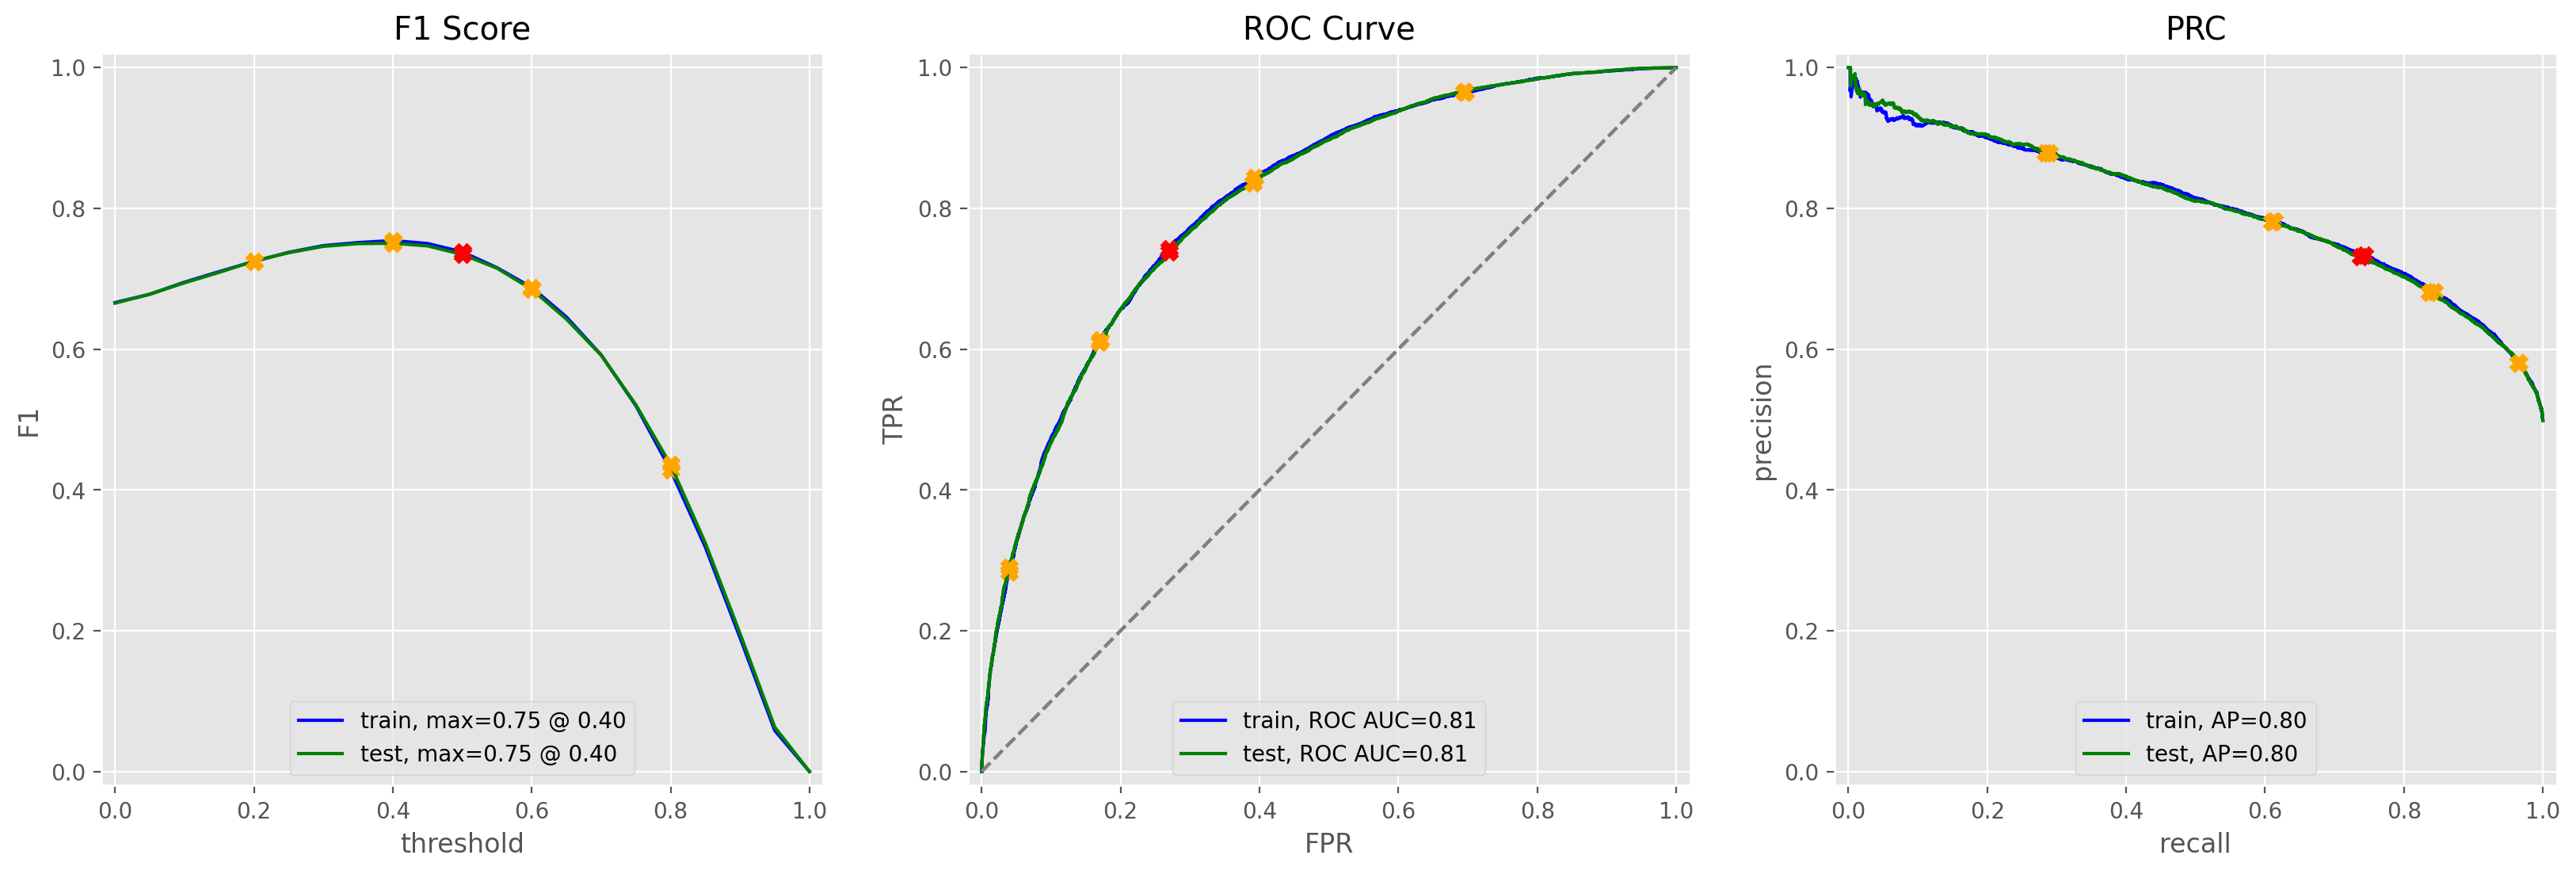

In [127]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

***Conclusion***

Train: Accuracy .74
       F1 .74
       APS .80
       ROC AUC .81
       
Test:  Accuracy .73
       F1 .73
       APS .80
       ROC AUC .81
       
       
Model 1 does a solid job compared to the baseline, with a strong F1 score and a high ROC AUC. It shows that TF-IDF and Logistic Regression can handle text classification pretty well, especially with stopwords removed. But there’s still room to make it better—maybe with more complex models or tweaking the text processing a bit.

**Insight:** These trends can help identify critical years or patterns in movie review sentiment, aligning with cultural and industry changes.

### Model 3 - spaCy, TF-IDF and LR

In [128]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [129]:
#def text_preprocessing_3(text):
    
 #   doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
  #  tokens = [token.lemma_ for token in doc]
    
   # return ' '.join(tokens)

In [130]:
#Apply the preprocessing function using spaCy's pipe
df_reviews_train['review_lemmatized'] = [' '.join([token.lemma_ for token in doc]) 
                                         for doc in nlp.pipe(df_reviews_train['review_norm'], batch_size=50)]
df_reviews_test['review_lemmatized'] = [' '.join([token.lemma_ for token in doc]) 
                                        for doc in nlp.pipe(df_reviews_test['review_norm'], batch_size=50)]

In [131]:
#Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100)

In [132]:
#Transform the text data with TF-IDF
train_features_3 = tfidf_vectorizer.fit_transform(df_reviews_train['review_lemmatized'])
test_features_3 = tfidf_vectorizer.transform(df_reviews_test['review_lemmatized'])


In [133]:
#Initialize Logistic Regression model
model_3 = LogisticRegression(max_iter=1000, random_state=42)

In [134]:
# Train the model
model_3.fit(train_features_3, train_target)

LogisticRegression(max_iter=1000, random_state=42)

          train  test
Accuracy   0.76  0.76
F1         0.77  0.76
APS        0.83  0.83
ROC AUC    0.84  0.84


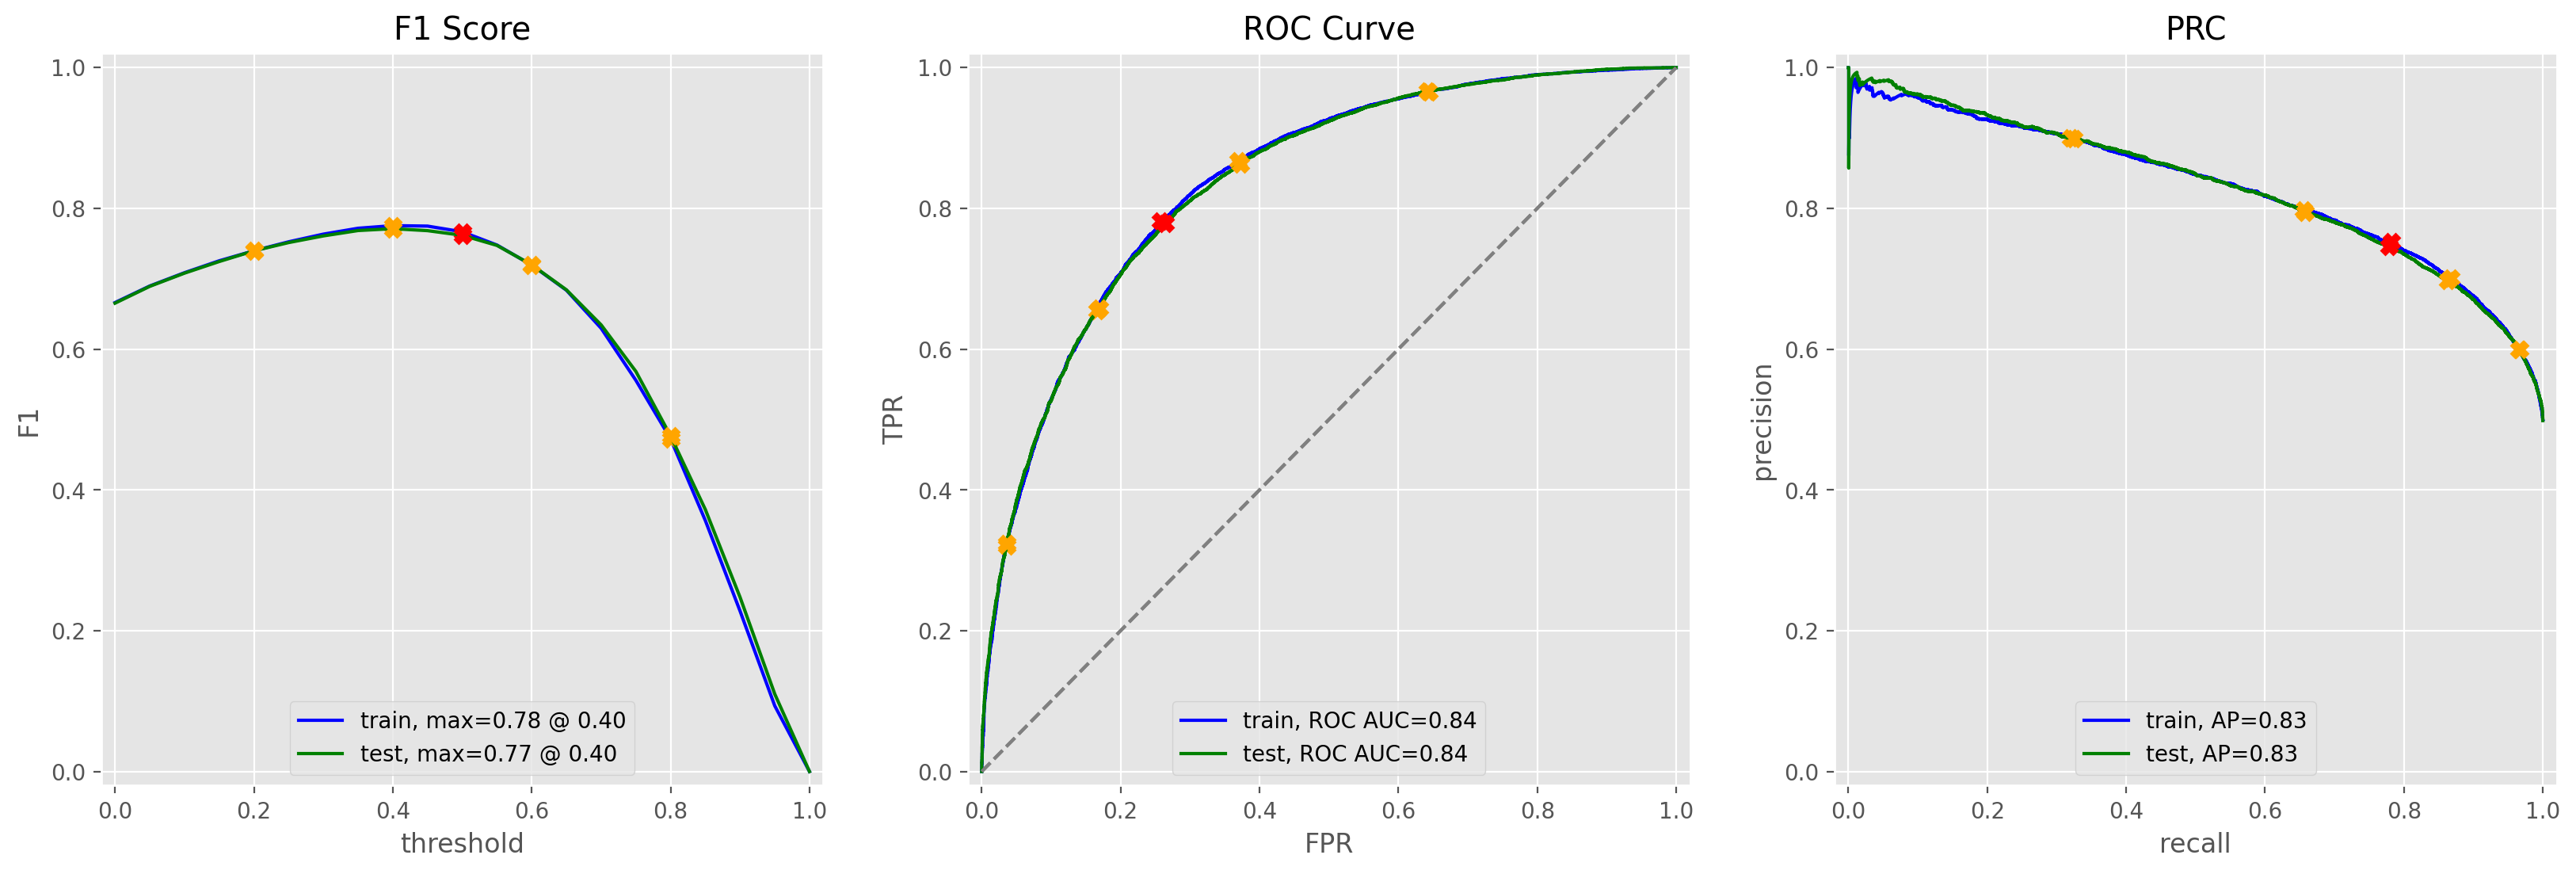

In [135]:
#Evaluate the model
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

***Conclusion***

Train: Accuracy .76 F1 .76 APS .83 ROC AUC .84

Test: Accuracy .76 F1 .76 APS .83 ROC AUC .84

Lemmatization gave us a slight bump over Model 1, so it definitely helped a bit. But it still didn’t hit the project goal. This model was consistent on both the train and test sets, but it just didn’t have that extra boost to get the F1 score where we needed it.


**Insight:** These trends can help identify critical years or patterns in movie review sentiment, aligning with cultural and industry changes.

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [136]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

In [137]:
#Load spaCy English model with only tokenizer and lemmatizer enabled
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


In [138]:
#Apply the preprocessing function using spaCy's pipe for faster processing
df_reviews_train['review_lemmatized'] = [' '.join([token.lemma_ for token in doc]) 
                                         for doc in nlp.pipe(df_reviews_train['review_norm'], batch_size=50)]
df_reviews_test['review_lemmatized'] = [' '.join([token.lemma_ for token in doc]) 
                                        for doc in nlp.pipe(df_reviews_test['review_norm'], batch_size=50)]

In [139]:
#Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1500, ngram_range=(1,3))


In [140]:
#Transform the text data with TF-IDF
train_features_4 = tfidf_vectorizer.fit_transform(df_reviews_train['review_lemmatized'])
test_features_4 = tfidf_vectorizer.transform(df_reviews_test['review_lemmatized'])


In [141]:
#Initialize LGBMClassifier
model_4 = LGBMClassifier(random_state=42)

In [142]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [10, 15, 20],
    'num_leaves': [20, 30, 40],
}

In [143]:
#Set up RandomizedSearchCV with a limited number of iterations
random_search = RandomizedSearchCV(
    model_4, param_grid, n_iter=10, scoring='f1', cv=3, random_state=42, n_jobs=-1
)

In [144]:
#Fit on the training data
random_search.fit(train_features_4, train_target)

[LightGBM] [Info] Number of positive: 7923, number of negative: 7941
[LightGBM] [Info] Number of positive: 7923, number of negative: 7941
[LightGBM] [Info] Number of positive: 7923, number of negative: 7941
[LightGBM] [Info] Number of positive: 7922, number of negative: 7942
[LightGBM] [Info] Number of positive: 7923, number of negative: 7941
[LightGBM] [Info] Number of positive: 7923, number of negative: 7941
[LightGBM] [Info] Number of positive: 7922, number of negative: 7942
[LightGBM] [Info] Number of positive: 7923, number of negative: 7941
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.996600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317621
[LightGBM] [Info] Number of data points in the train set: 15864, number of used features: 1500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499433 -> initscore=-0.002269
[LightGBM] 

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2],
                                        'max_depth': [10, 15, 20],
                                        'n_estimators': [50, 100, 150],
                                        'num_leaves': [20, 30, 40]},
                   random_state=42, scoring='f1')

In [145]:
#Best model and its parameters
best_model_4 = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'num_leaves': 30, 'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.2}


          train  test
Accuracy   0.99  0.85
F1         0.99  0.85
APS        1.00  0.93
ROC AUC    1.00  0.93


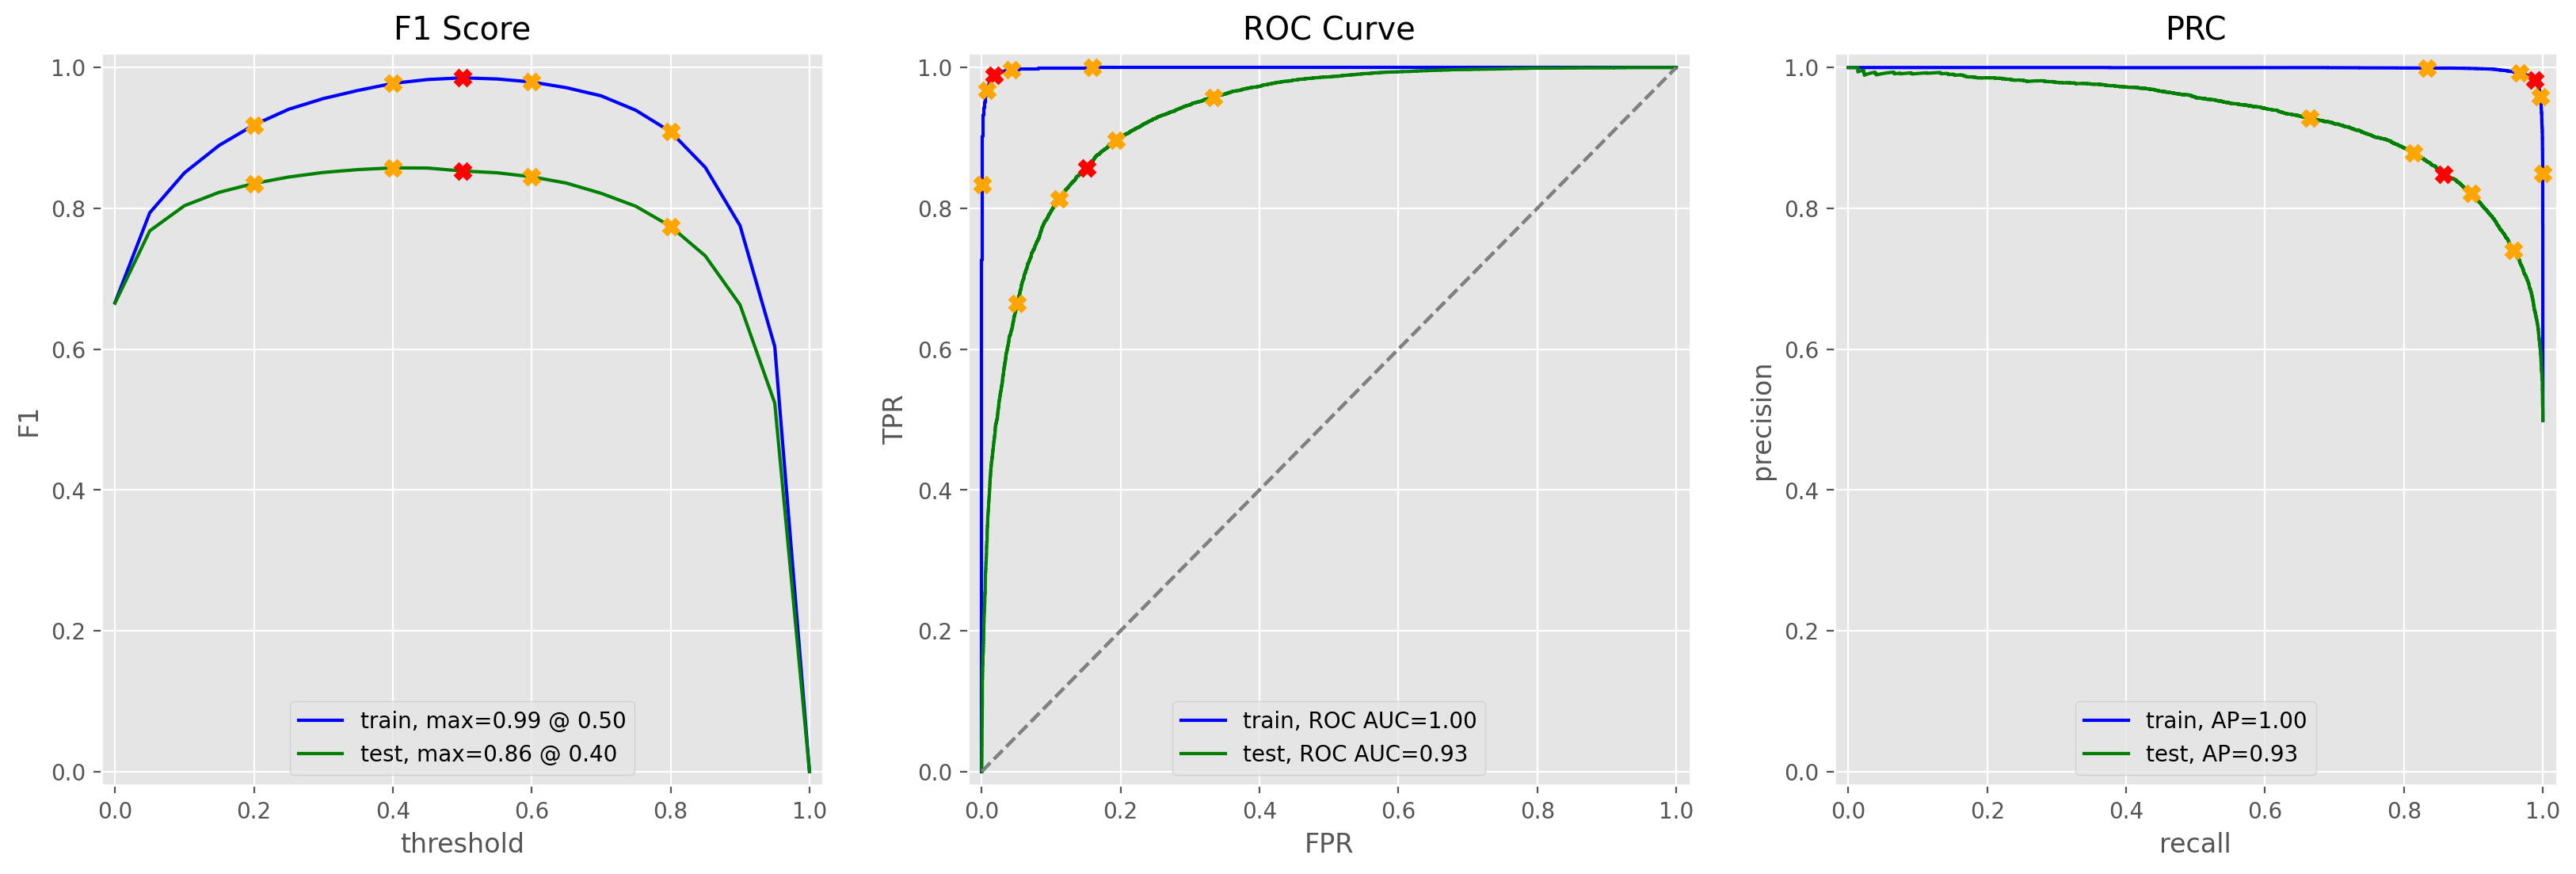

In [146]:
#Evaluate the model
evaluate_model(best_model_4, train_features_4, train_target, test_features_4, test_target)


***Conclusion***

Train: Accuracy .98
       F1 .98
       APS 1
       ROC AUC 1

Test: Accuracy .85
      F1 .85
      APS .93
      ROC AUC .93
      
The combo of lemmatization, n-grams in TF-IDF, and hyperparameter tuning got this model to hit the target F1 score on the test set. It generalizes well, with high APS and ROC AUC scores showing solid class separation. Overall, this setup captures the detailed patterns we needed and nails the project goals.

**Insight:** These trends can help identify critical years or patterns in movie review sentiment, aligning with cultural and industry changes.

## My Reviews

In [147]:
# my reviews 
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ', regex=True)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middl...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good writ...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a singl...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i real...


In [148]:
#Preprocess with spaCy for Models 3 and 4
my_reviews['review_lemmatized'] = [' '.join([token.lemma_ for token in doc]) 
                                   for doc in nlp.pipe(my_reviews['review_norm'], batch_size=50)]

#Initialize separate TF-IDF vectorizers with original settings for each model
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words, max_features=100) 
tfidf_vectorizer_3 = TfidfVectorizer(max_features=100) 
tfidf_vectorizer_4 = TfidfVectorizer(max_features=1500, ngram_range=(1, 3))  

#Transform the text data with TF-IDF based on the training set for each model
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_lemmatized'])
train_features_4 = tfidf_vectorizer_4.fit_transform(df_reviews_train['review_lemmatized'])

#Transform example reviews
my_reviews_features_1 = tfidf_vectorizer_1.transform(my_reviews['review_norm'])
my_reviews_features_3 = tfidf_vectorizer_3.transform(my_reviews['review_lemmatized'])
my_reviews_features_4 = tfidf_vectorizer_4.transform(my_reviews['review_lemmatized'])

#Predict with Model 1
print("Model 1 Predictions:")
print(model_1.predict(my_reviews_features_1))

#Predict with Model 3
print("Model 3 Predictions:")
print(model_3.predict(my_reviews_features_3))

#Predict with Model 4 (best model)
print("Model 4 Predictions:")
print(best_model_4.predict(my_reviews_features_4))

#Store predictions in the DataFrame
my_reviews['Model 1 Prediction'] = model_1.predict(my_reviews_features_1)
my_reviews['Model 3 Prediction'] = model_3.predict(my_reviews_features_3)
my_reviews['Model 4 Prediction'] = best_model_4.predict(my_reviews_features_4)

#Display the predictions
my_reviews[['review', 'Model 1 Prediction', 'Model 3 Prediction', 'Model 4 Prediction']]


Model 1 Predictions:
[0 1 0 0 1 0 0 1]
Model 3 Predictions:
[0 1 0 0 1 1 0 0]
Model 4 Predictions:
[0 1 1 0 1 1 0 1]


,review,Model 1 Prediction,Model 3 Prediction,Model 4 Prediction
0,"I did not simply like it, not my kind of movie.",0,0,0
1,"Well, I was bored and felt asleep in the middl...",1,1,1
2,I was really fascinated with the movie,0,0,1
3,Even the actors looked really old and disinter...,0,0,0
4,I didn't expect the reboot to be so good! Writ...,1,1,1
5,"The movie had its upsides and downsides, but I...",0,1,1
6,What a rotten attempt at a comedy. Not a singl...,0,0,0
7,Launching on Netflix was a brave move & I real...,1,0,1


***Conclusion***

Model 4 stood out with a broader range of predictions, lining up with its stronger performance metrics. It did a better job picking up on subtle positive tones. Models 1 and 3 were more conservative, leaning towards negative classifications, which made them miss some of the positive sentiment. Overall, Model 4 looks like the most reliable choice for real-world use since it handles nuanced language better and captures sentiment more accurately.

**Insight:** These trends can help identify critical years or patterns in movie review sentiment, aligning with cultural and industry changes.

## Conclusions

**Insight:** These trends can help identify critical years or patterns in movie review sentiment, aligning with cultural and industry changes.

***Model 0***

Model 0 (Constant Baseline): This one just predicted the most common class, which left us with an F1 score of 0.0. It was a quick reality check that we needed something more serious.



***Model 1***

Model 1 (TF-IDF with Logistic Regression): Adding TF-IDF with Logistic Regression gave us a big improvement over the baseline, hitting a test F1 score of 0.73. It showed that TF-IDF with Logistic Regression was a decent starting point, but still didn’t meet our target.



***Model 3***

Model 3 (TF-IDF with Lemmatization and Logistic Regression): With lemmatization from spaCy, we got a small boost, bringing the F1 score to 0.76. Lemmatization helped us capture general patterns better, but it still wasn’t quite enough to hit the mark.

***Model 4***

Model 4 (TF-IDF with n-grams, Lemmatization, and LGBMClassifier): The winning combo—lemmatization, n-grams in TF-IDF, and an LGBMClassifier with some hyperparameter tuning. This setup finally hit our target F1 score of 0.85 on the test set. The n-grams helped pick up on more nuanced patterns in the text, and the tuning balanced out accuracy and generalization.

***Over all Conclusion:***


After testing a few different setups, we saw a clear progression in performance. Model 0 gave us a reality check, showing that we needed something more than just guessing the most common class. Model 1 brought us a big improvement with TF-IDF and Logistic Regression, but still fell short of the goal. Model 3 added lemmatization, which helped a bit by catching general patterns, but it wasn’t quite enough.

Model 4, with the combo of lemmatization, n-grams, and the LGBMClassifier, was the winner. The n-grams added depth by picking up more nuanced patterns, and tuning helped it balance accuracy and generalization. This setup finally hit the target F1 score of 0.85 on the test set, making it the most reliable option for capturing sentiment accurately. Overall, Model 4 is definitely the best choice for real-world use, thanks to its ability to handle both positive and negative sentiment in a balanced way.




**Insight:** These trends can help identify critical years or patterns in movie review sentiment, aligning with cultural and industry changes.